In [1]:
#
# Convolutional AutoEncoder MNIST
#
# @author becxer
# @email becxer87@gmail.com
# @reference https://github.com/sjchoi86/Tensorflow-101
#

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline  

print ("packages are loaded")

packages are loaded


In [2]:
# Get MNIST data set from tensorflow
from tensorflow.examples.tutorials.mnist import input_data
mnist_set = input_data.read_data_sets('images/MNIST/', one_hot = True)

train_img = mnist_set.train.images
train_label = mnist_set.train.labels
test_img = mnist_set.test.images
test_label = mnist_set.test.labels

noise_lev = 0.3
train_img_noised = train_img + noise_lev * np.random.randn(train_img.shape[0], train_img.shape[1])
test_img_noised = test_img + noise_lev * np.random.randn(test_img.shape[0], test_img.shape[1])
print ("Noised data prepared")

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Noised data prepared


In [3]:
# Options for training
learning_rate = 0.001
training_epochs = 50
batch_size = 100
display_step = 10

# Options for Convolution
x_conv_shape =  [-1,28,28,1] # because MNIST data is oneline

n_encode_conv = [[3,3,1,16],[3,3,16,32]]
n_encode_strides = [[1,2,2,1],[1,2,2,1]]
n_decode_conv = [[3,3,16,32],[3,3,1,16]]
n_decode_shapes = [[-1,14,14,16], x_conv_shape]
n_decode_strides = [[1,2,2,1],[1,2,2,1]]

w_dev = 0.1

# Options for dropout
drop_out_ratio = 0.7

In [4]:
# Build Graph of Convolution Auto Encoder

# Define placeholder & Variables
x = tf.placeholder("float", [None, train_img.shape[1]])
y = tf.placeholder("float", [None, train_img.shape[1]])
drop_out_prob = tf.placeholder("float")

def one_cnn_encode(_x, _weight_E, _stride_E, _bias_E, _dop):
    _conv1_E = tf.nn.conv2d(_x, _weight_E, strides=_stride_E, padding='SAME')
    _conv2_E = tf.nn.bias_add(_conv1_E, _bias_E)
    _conv3_E = tf.nn.sigmoid(_conv2_E)
    _out_E = tf.nn.dropout(_conv3_E, _dop)
    return {'conv1':_conv1_E, 'conv2':_conv2_E, 'conv3':_conv3_E, 'out':_out_E}

def one_cnn_decode(_x, _weight_D, _target_S, _stride_D, _bias_D, _dop):
    _conv1_D = tf.nn.conv2d_transpose(_x, _weight_D, _target_S, strides=_stride_D, padding='SAME')
    _conv2_D = tf.nn.bias_add(_conv1_D, _bias_D)
    _conv3_D = tf.nn.sigmoid(_conv2_D)
    _out_D = tf.nn.dropout(_conv3_D, _dop)
    return {'conv1':_conv1_D, 'conv2':_conv2_D, 'conv3':_conv3_D, 'out':_out_D}

WS = {}
BS = {}

last_input_layer = tf.reshape(x, shape = x_conv_shape)
for idx in range(len(n_encode_conv)):
    _weight_E = tf.Variable(tf.random_normal(n_encode_conv[idx], stddev=w_dev))
    _stride_E = n_encode_strides[idx]
    _bias_E = tf.Variable(tf.random_normal([n_encode_conv[idx][-1]], stddev=w_dev))
    layer = one_cnn_encode(last_input_layer, _weight_E, _stride_E, _bias_E, drop_out_prob)
    last_input_layer = layer['out']
    WS['ce_' + str(idx)] = _weight_E
    BS['be_' + str(idx)] = _bias_E
    
for idx in range(len(n_decode_conv)):
    _weight_D = tf.Variable(tf.random_normal(n_decode_conv[idx], stddev=w_dev))
    _target_S = n_decode_shapes[idx]
    _target_S[0] = tf.shape(last_input_layer)[0]
    _target_S = tf.pack(_target_S)
    _stride_D = n_decode_strides[idx]
    _bias_D = tf.Variable(tf.random_normal([n_decode_conv[idx][-2]], stddev=w_dev))
    layer = one_cnn_decode(last_input_layer, _weight_D, _target_S, _stride_D, _bias_D, drop_out_prob)
    last_input_layer = layer['out']
    WS['cd_' + str(idx)] = _weight_D
    BS['bd_' + str(idx)] = _bias_D

# Define operators
out = last_input_layer
cost = tf.reduce_sum(tf.square(out-tf.reshape(y,x_conv_shape)))
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

init = tf.initialize_all_variables()
print ("Graph build")

Graph build


epoch: 000/050  ,  cost: 8063.233850


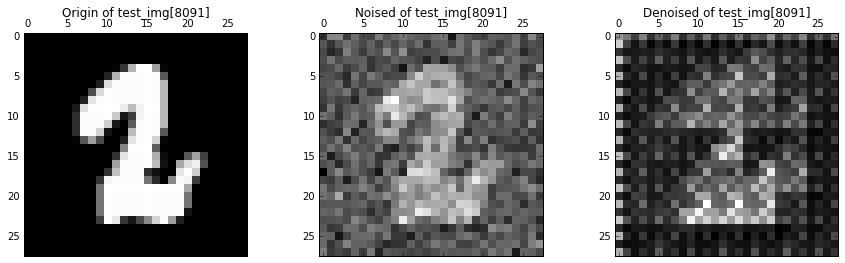

epoch: 010/050  ,  cost: 1452.490818


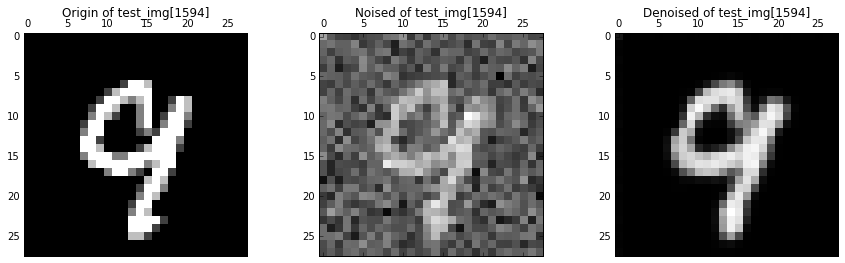

epoch: 020/050  ,  cost: 1352.430044


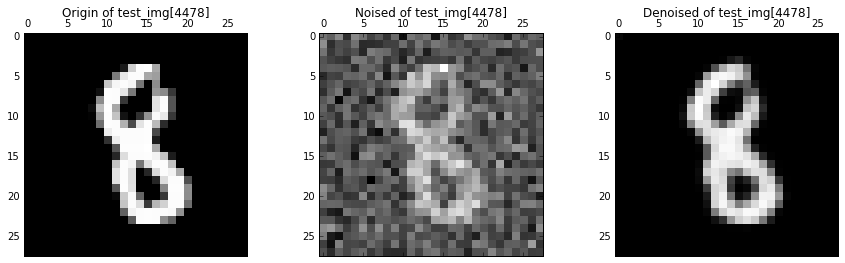

epoch: 030/050  ,  cost: 1321.515840


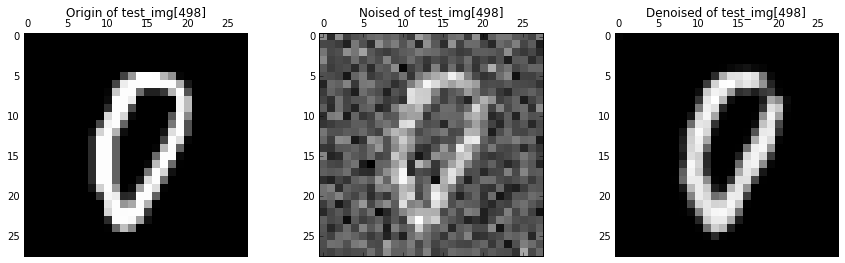

epoch: 040/050  ,  cost: 1310.199611


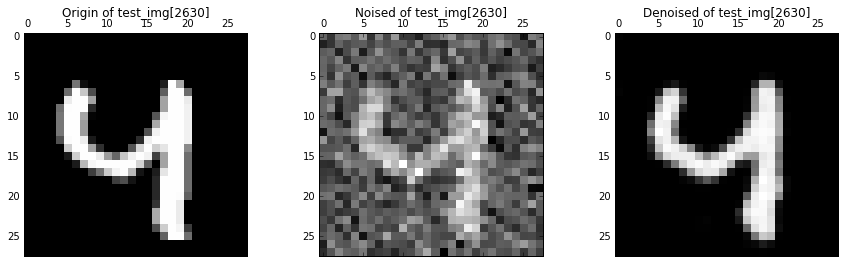

Training complete


In [5]:
# Training Graph
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    avg_cost = 0.
    num_batch = int(train_img.shape[0]/batch_size)
    for i in range(num_batch):
        randidx = np.random.randint(train_img.shape[0], size=batch_size)
        batch_xs = train_img_noised[randidx, :]
        batch_ys = train_img[randidx, :] 
        
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : drop_out_ratio})
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : 1.})/num_batch
            
    if epoch % display_step == 0:
        print ("epoch: %03d/%03d  ,  cost: %.6f"% (epoch, training_epochs, avg_cost))
        
        rdx = np.random.randint(test_img.shape[0], size=1)
        original_one = test_img[rdx,:]
        noised_one = test_img_noised[rdx,:]
        out_one = sess.run(out, {x:noised_one, drop_out_prob : 1.})
        
        fig, axs = plt.subplots(1, 3, figsize=(15,4))
        axs[0].matshow(np.reshape(original_one, (28,28)), cmap=plt.get_cmap('gray'))
        axs[0].set_title("Origin of test_img" + str(rdx))
        axs[1].matshow(np.reshape(noised_one, (28,28)), cmap=plt.get_cmap('gray'))
        axs[1].set_title("Noised of test_img" + str(rdx))
        axs[2].matshow(np.reshape(out_one, (28,28)), cmap=plt.get_cmap('gray'))
        axs[2].set_title("Denoised of test_img" + str(rdx))
        plt.show()
        

print ("Training complete")